<a href="https://colab.research.google.com/github/ajaykumar-br/Brain-Tumor-Classification/blob/main/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps

!pip install nilearn
!pip install nibabel
# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

!pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif
# import gif_your_nifti.core as gif2nif


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 30.1 MB/s eta 0:00:00
  Cloning https://github.com/miykael/gif_your_nifti to /tmp/pip-req-build-rlk5yh2o
  Running command git clone --filter=blob:none --quiet https://github.com/miykael/gif_your_nifti /tmp/pip-req-build-rlk5yh2o
  Resolved https://github.com/miykael/gif_your_nifti to commit fc21f44a57d04a6ae471ba4be6da0f904d830669
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 13.9 MB/s eta 0:00:00
  Created wheel for gif-your-nifti: filename=gif_your_nifti-0.2.1-py3-none-any.whl size=6391 sha256=f61c354fe778ceabd9900ef6c4717b555f03658b52601733c9d50792c49e4347
  Stored in directory: /tmp/pip-ephem-wheel-cache-fyfkoyf9/wheels/3a/c2/0b/c08f2425925519bb014e107d2919dadc2556ec5e7c205e4472
Successfully built gif-your-nifti
  Attempting uninstall: imageio
    Found existing installation: imageio 2.31.6
    Uninstalling imageio-2.31.6:
      Successfully uninstalled imageio-2.31.6


In [ ]:
# Mount your google drive first

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# At first you need to download the api json file of your account from kaggle and upload it in google colab and then put the folder path of that json file as shown below

import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
# Then download the dataset and then unzip it in your drive using the below code

!kaggle datasets download -d aryashah2k/brain-tumor-segmentation-brats-2019
!unzip '/content/brain-tumor-segmentation-brats-2019.zip' -d '/content/drive/MyDrive'

In [ ]:
# DEFINE seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE - RED
    2 : 'EDEMA',  # Green
    3 : 'ENHANCING' # original 4 -> converted into 3 later, Yellow
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include

IMG_SIZE=128

(240, 240, 155)


Text(0.5, 1.0, 'Mask')

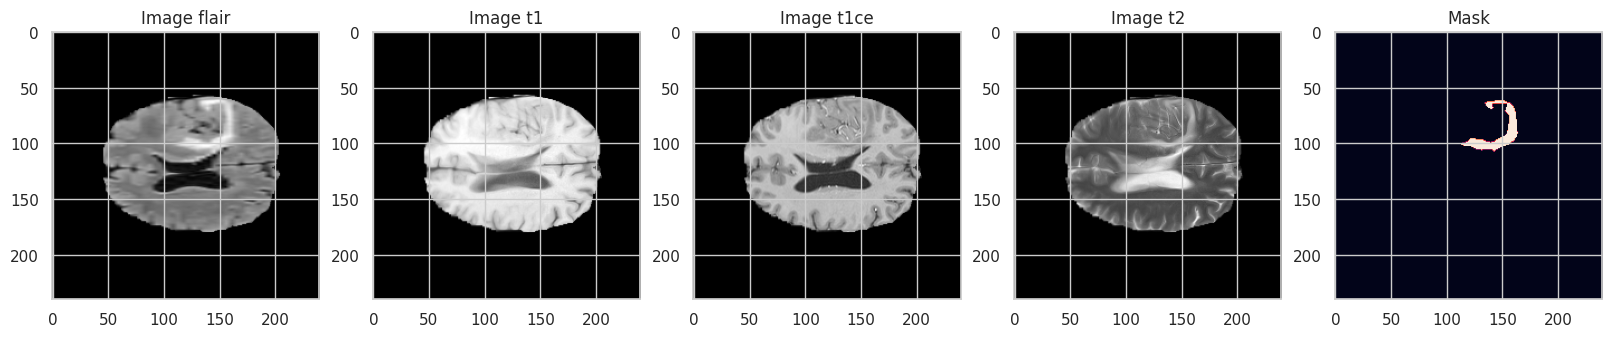

In [ ]:
# Here you need to put your directory of the dataset

#TRAIN_DATASET_PATH = '../input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training/HGG/'
TRAIN_DATASET_PATH = '/content/drive/MyDrive/MICCAI_BraTS_2019_Data_Training/HGG/'
#VALIDATION_DATASET_PATH = '../input/d/debobratachakraborty/brats2019-dataset/MICCAI_BraTS_2019_Data_Training/'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS19_2013_10_1/BraTS19_2013_10_1_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS19_2013_10_1/BraTS19_2013_10_1_t1.nii').get_fdata()

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS19_2013_10_1/BraTS19_2013_10_1_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS19_2013_10_1/BraTS19_2013_10_1_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS19_2013_10_1/BraTS19_2013_10_1_seg.nii').get_fdata()

print(test_image_flair.shape)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

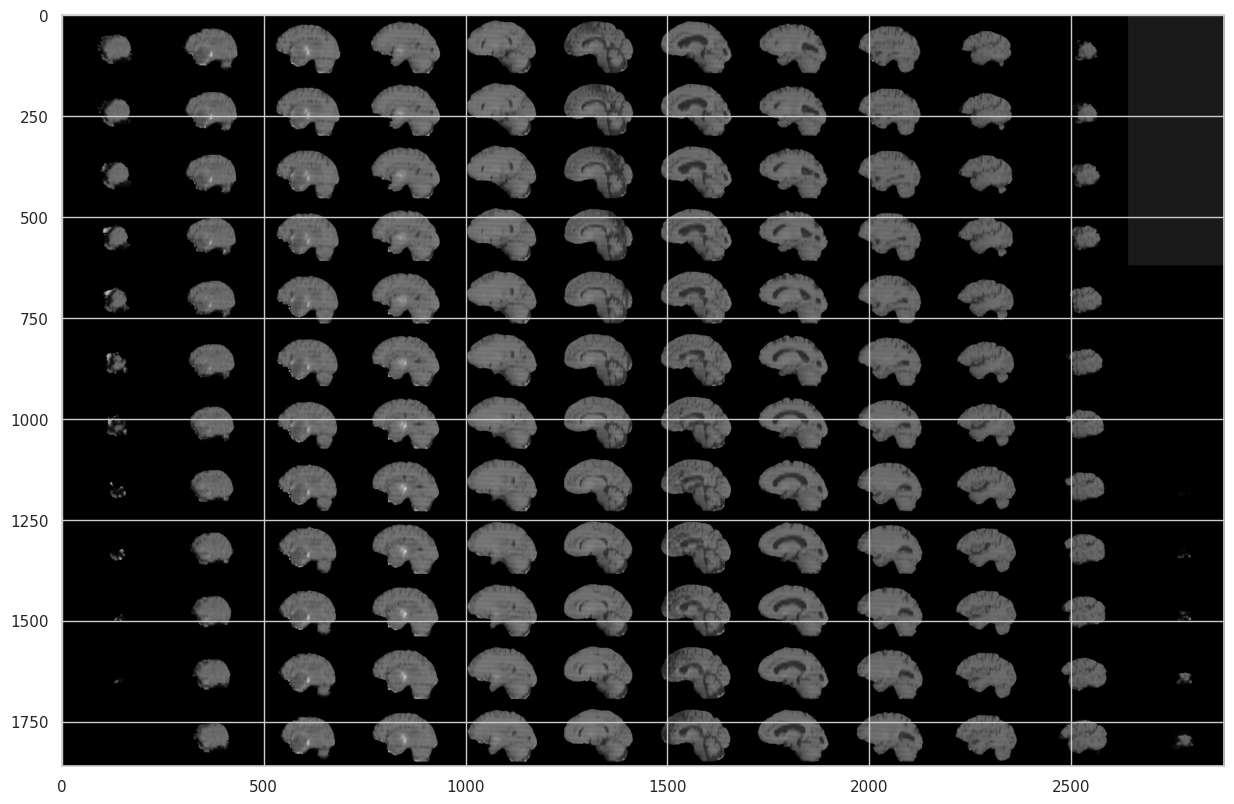

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

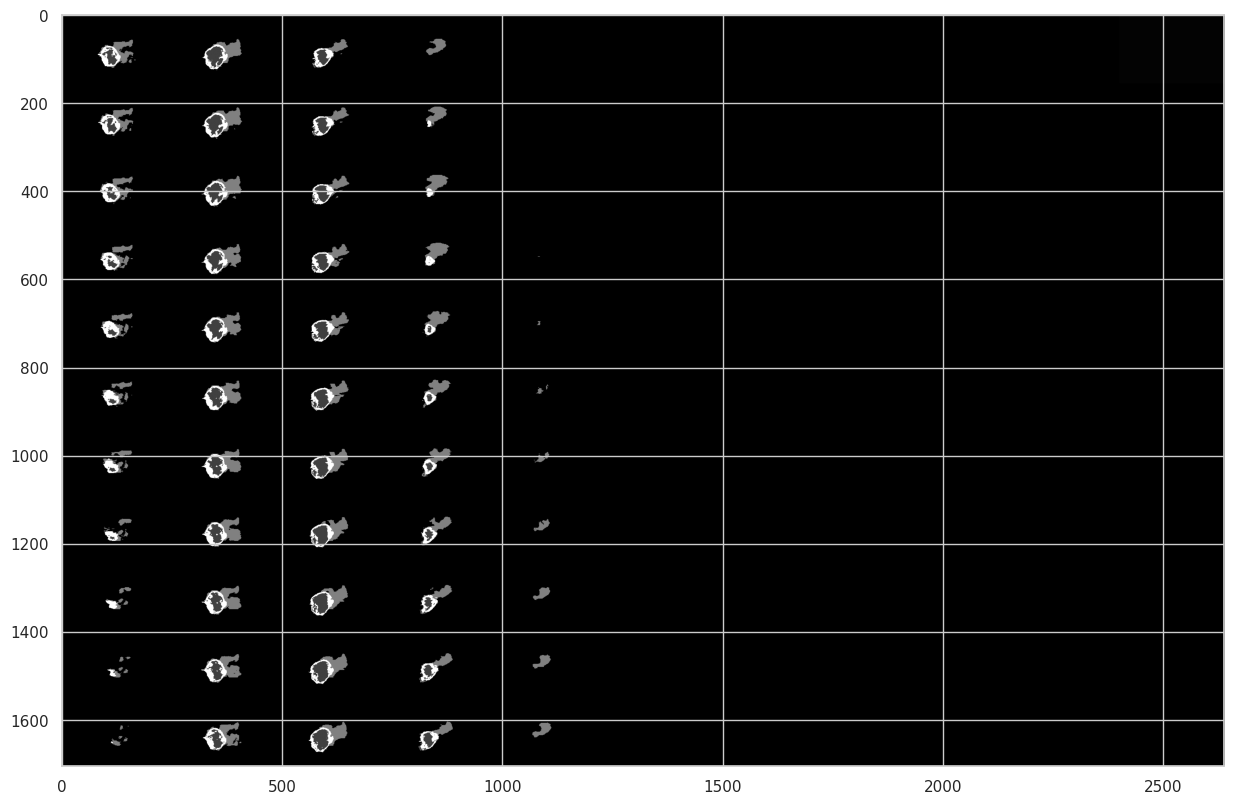

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

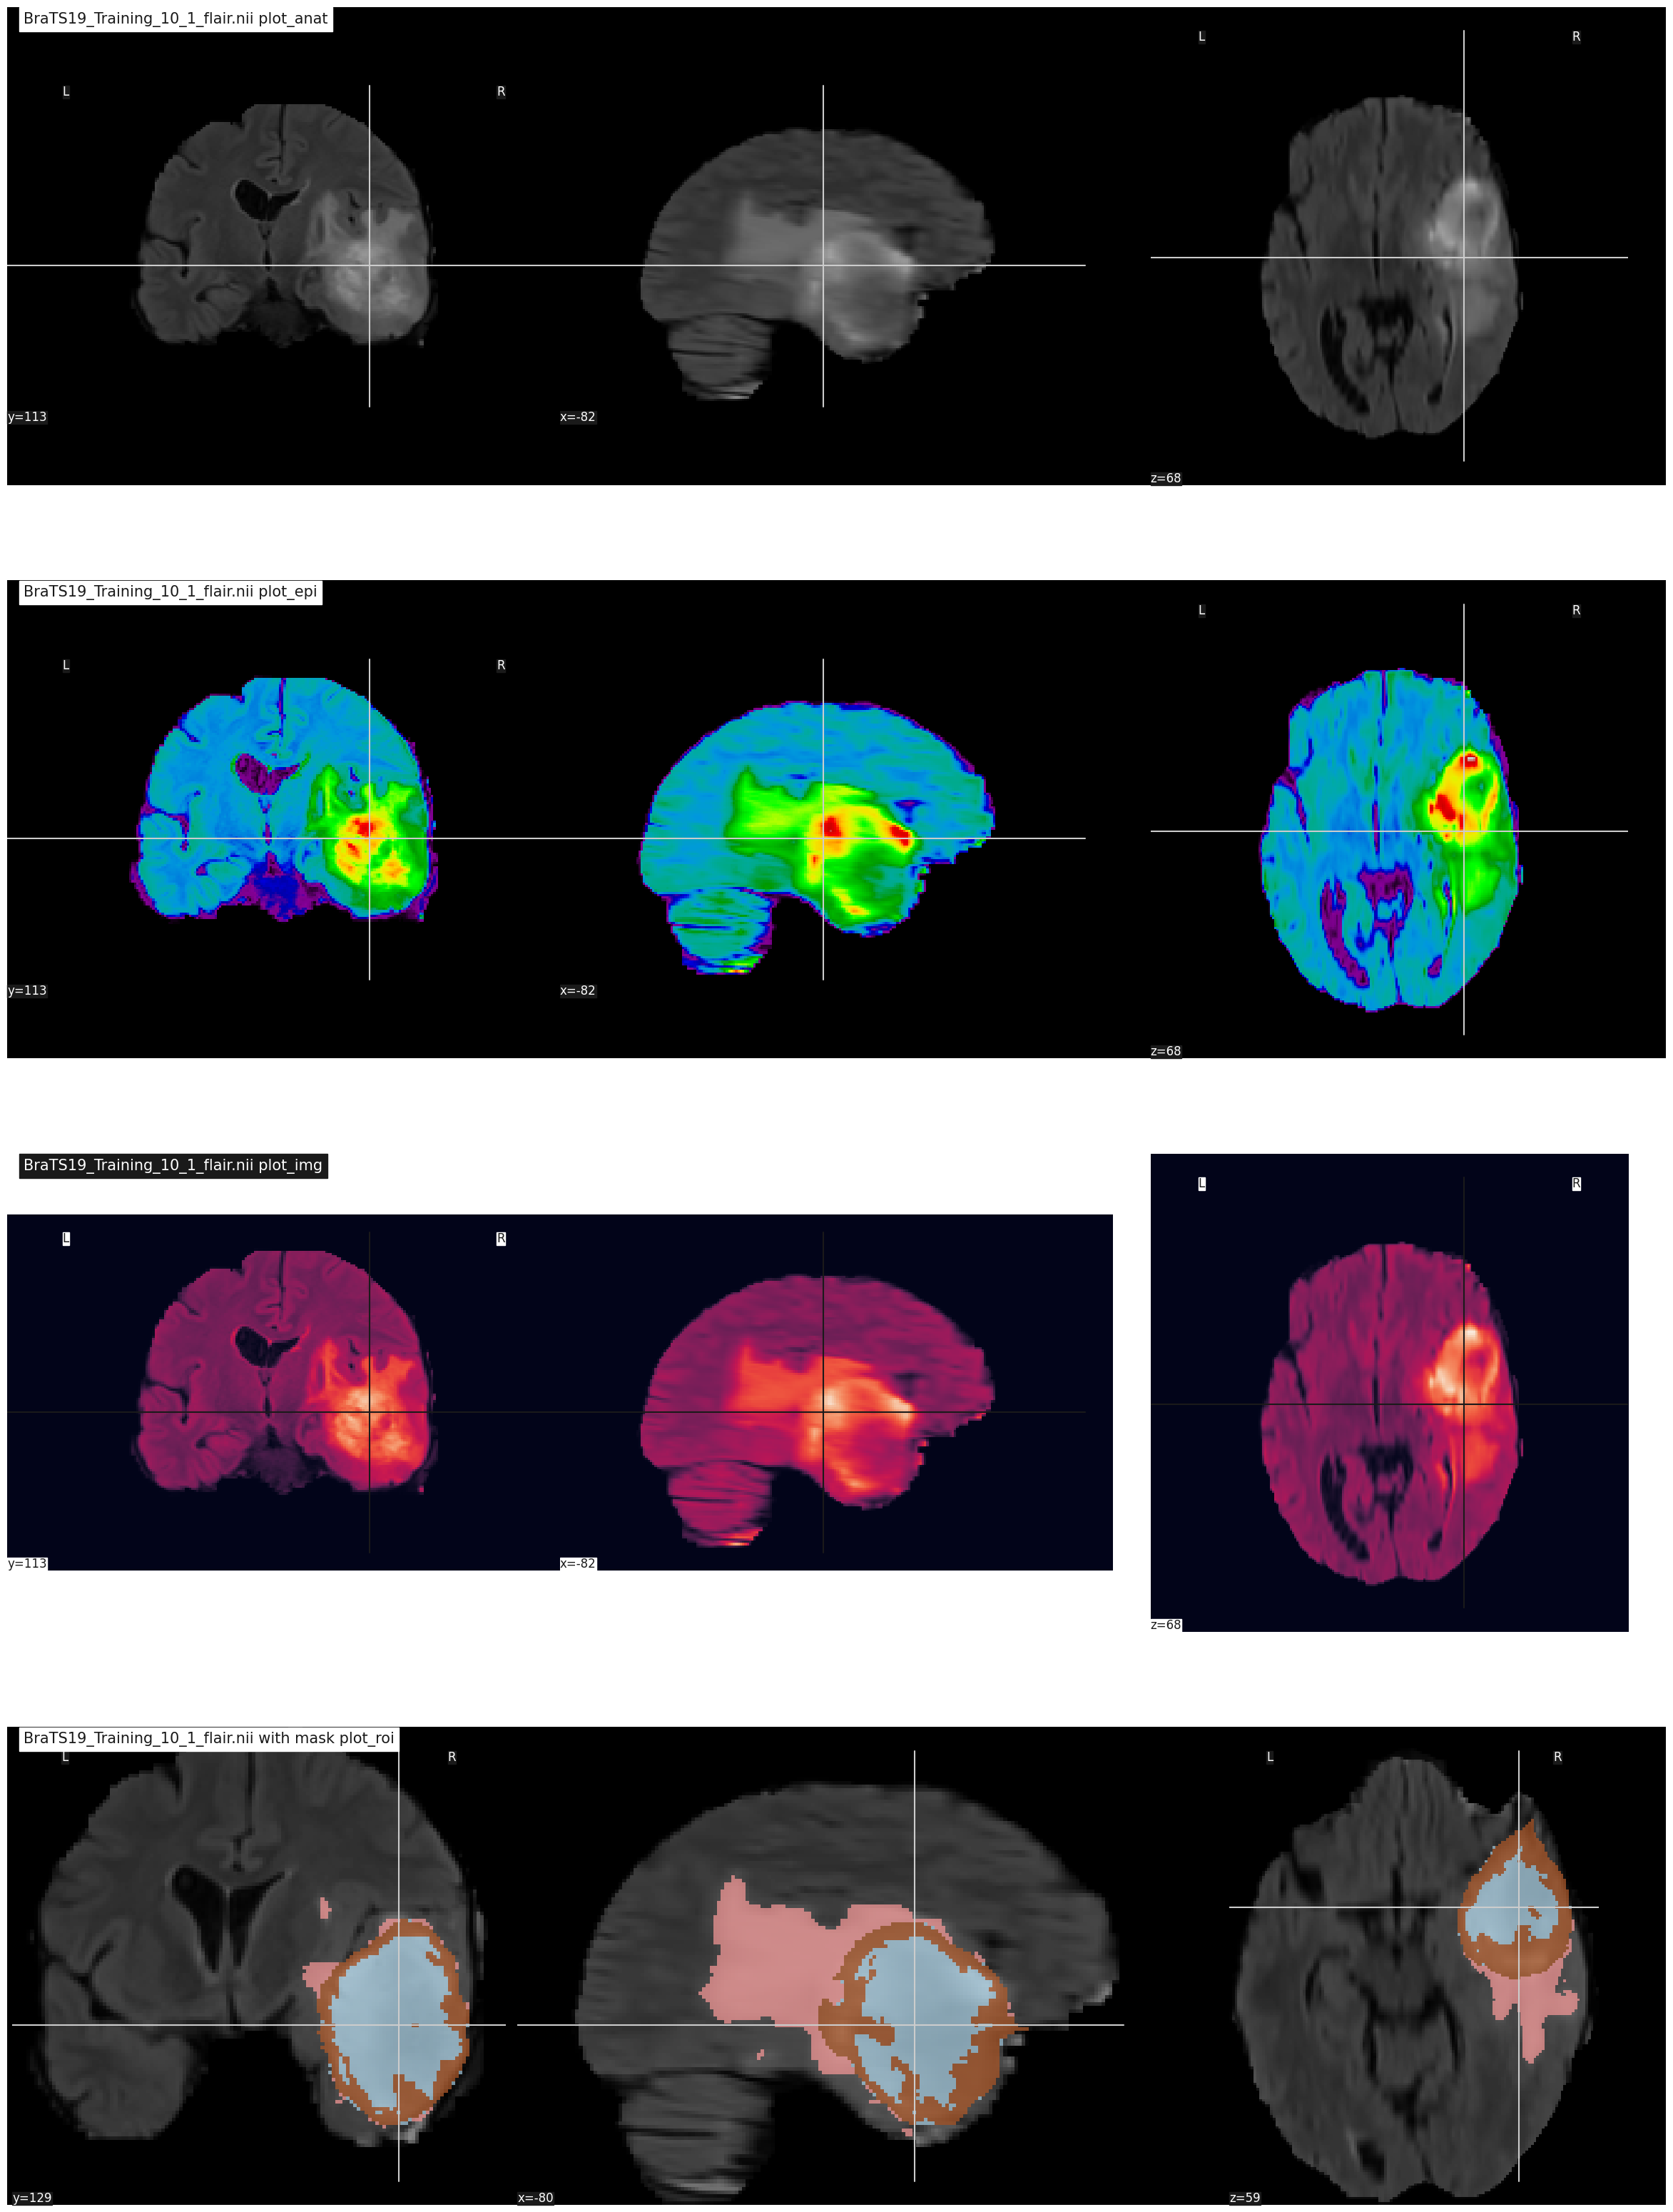

In [ ]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS19_2013_10_1/BraTS19_2013_10_1_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS19_2013_10_1/BraTS19_2013_10_1_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS19_Training_10_1_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS19_Training_10_1_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS19_Training_10_1_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask,
               title='BraTS19_Training_10_1_flair.nii with mask plot_roi',
               bg_img=niimg,
               axes=axes[3], cmap='Paired')

plt.show()

In [ ]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss

    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss



# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
# Building U-Net

def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

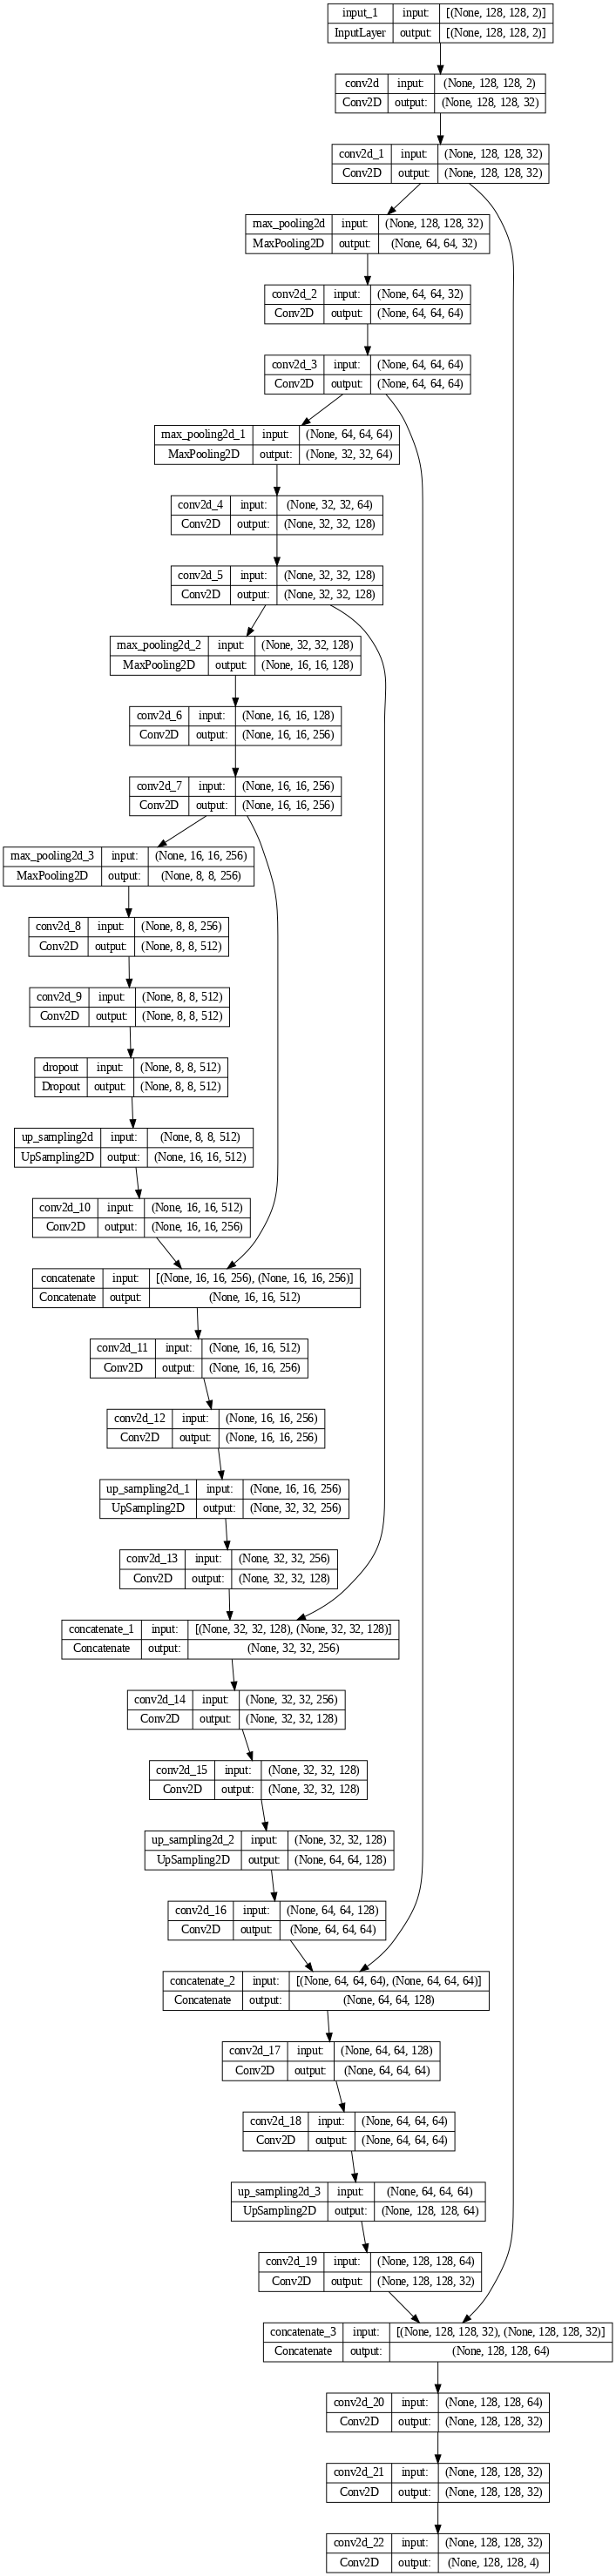

In [ ]:
# Plotting U-Net

plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

In [ ]:
# Splitting the directories into train test and validation

# lists of directories with studies

train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

print(train_and_val_directories)
# file BraTS20_Training_355 has ill formatted name for for seg.nii file
#train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);

print(train_and_test_ids)

train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

print(train_ids)
print(test_ids)
print(val_ids)

['/content/drive/MyDrive/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1', '/content/drive/MyDrive/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_11_1', '/content/drive/MyDrive/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_12_1', '/content/drive/MyDrive/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_13_1', '/content/drive/MyDrive/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_14_1', '/content/drive/MyDrive/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_17_1', '/content/drive/MyDrive/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_18_1', '/content/drive/MyDrive/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_19_1', '/content/drive/MyDrive/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_20_1', '/content/drive/MyDrive/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_21_1', '/content/drive/MyDrive/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_22_1', '/content/drive/MyDrive/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_23_1', '/content/drive/MyDrive/MICCAI_BraTS_20

In [ ]:
# Data Generation and Preprocessing

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE),interpolation=cv2.INTER_LINEAR);
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE),interpolation=cv2.INTER_LINEAR);

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        # print(y)
        # print(np.max(y))
        # print(np.min(y))
        #print(y.shape)
        mask = tf.one_hot(y, 4);
        #print(mask.shape)
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        #print(Y.shape)
        # print(X.shape)
        return X/np.max(X), Y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

X,y = test_generator.__getitem__(0)

print(y.shape)
print(X.shape)

(100, 128, 128, 4)
(100, 128, 128, 2)


In [ ]:
print(len(train_ids))
print(len(val_ids))
print(len(test_ids))

175
52
32


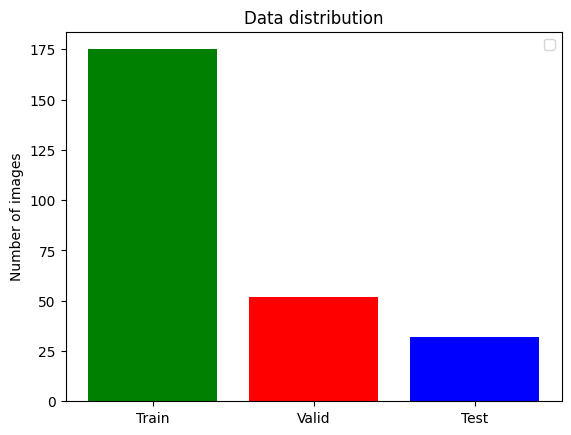

In [ ]:
# show number of data for each dir
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')
    plt.savefig('data2019.png')
    plt.show()

showDataLayout()

In [ ]:
# Training U-Net Model

save_path='/content/drive/MyDrive/brats_model_1.h5'

callbacks_save=keras.callbacks.ModelCheckpoint(save_path,monitor='val_loss', verbose=0, save_best_only=True, period=1)

history =  model.fit(training_generator,
                    epochs=90,
                    steps_per_epoch=len(train_ids),
                    callbacks=[callbacks_save],
                    validation_data = valid_generator
                    )

In [ ]:
# Retraining U-Net model from the save file

#csv_logger = CSVLogger('training_2019_50.log')
model = tf.keras.models.load_model('/content/drive/MyDrive/brats_model_1.h5',
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  })

#model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )
save_path='/content/drive/MyDrive/brats_model_1.h5'

callbacks_save=keras.callbacks.ModelCheckpoint(save_path,monitor='val_loss', verbose=0, save_best_only=True, period=1)

history =  model.fit(training_generator,
                    epochs=90,
                    steps_per_epoch=len(train_ids),
                    callbacks=[callbacks_save],
                    validation_data = valid_generator
                    )
#model.save("/content/drive/MyDrive/BraTS_2019_model_1.h5")

In [ ]:
# Testing U-Net Model

model = tf.keras.models.load_model('/content/drive/MyDrive/brats_model_1.h5',
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  })

score=model.evaluate(test_generator)

print("Test Loss : "+str(score[0]))
print("Test Accuracy : "+str(score[1]))

32/32 [==============================] - 121s 3s/step - loss: 0.0096 - accuracy: 0.9965 - mean_io_u: 0.8192 - dice_coef: 0.7537 - precision: 0.9963 - sensitivity: 0.9954 - specificity: 0.9987 - dice_coef_necrotic: 0.7880 - dice_coef_edema: 0.8802 - dice_coef_enhancing: 0.8806
Test Loss : 0.009580789133906364
Test Accuracy : 0.9965353608131409


In [ ]:
!pip install tabulate

In [ ]:
# Loading U-Net for prediction

model = tf.keras.models.load_model('/content/drive/MyDrive/brats_model_1.h5',
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  })

In [ ]:
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] )
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)

/content/drive/MyDrive/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_CBICA_ASK_1
4/4 [==============================] - 0s 69ms/step


<Figure size 1800x5000 with 0 Axes>

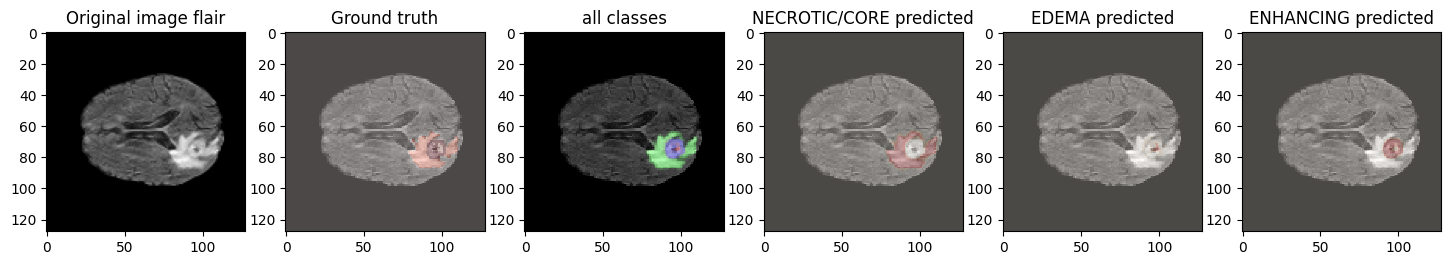

In [ ]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))

    vol_path = os.path.join(case_path, f'{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata()

 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()


    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"/content/drive/MyDrive/MICCAI_BraTS_2019_Data_Training/HGG/{case}"
    print(path)
    gt = nib.load(os.path.join(path, f'{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50))

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.savefig('Test_01.png')
    plt.show()


showPredictsById(case=test_ids[1])
#showPredictsById(case=test_ids[1][-3:])
#showPredictsById(case=test_ids[2][-3:])
#showPredictsById(case=test_ids[3][-3:])
#showPredictsById(case=test_ids[4][-3:])
#showPredictsById(case=test_ids[5][-3:])
#showPredictsById(case=test_ids[6][-3:])

In [ ]:
# Building AlexNet

np.random.seed(1000)

#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(128,128,2), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(65536))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))
AlexNet.add(Reshape((128,128,4)))

#Model Summary
AlexNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 32, 32, 96)        23328     
                                                                 
 batch_normalization (Batch  (None, 32, 32, 96)        384       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 32, 32, 96)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 16, 16, 256)       614656    
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 256)       1

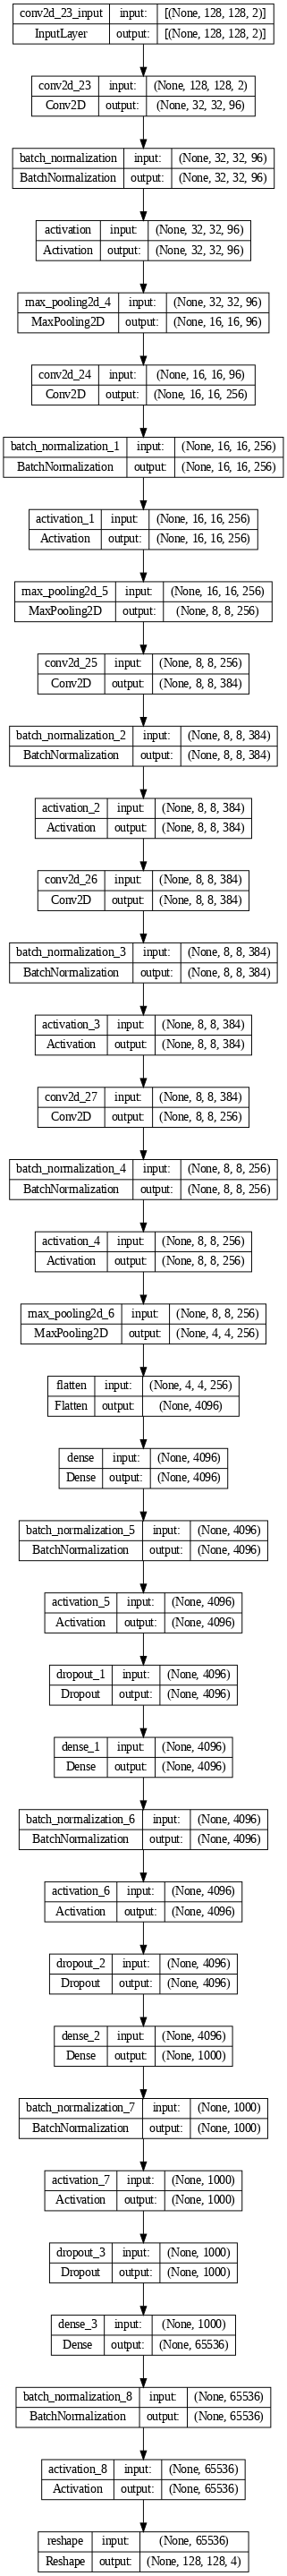

In [ ]:
# Plotting AlexNet Architecture

plot_model(AlexNet,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

In [ ]:
# Training with AlexNet

AlexNet.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy', tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing])

alex_net_history='/content/drive/MyDrive/alex_net_history.csv'
alex_net_history_callback=tf.keras.callbacks.CSVLogger(alex_net_history, separator=",", append=True)

alex_net_best_model='/content/drive/MyDrive/alex_net_best_model.h5'

callbacks_save_best_model_alex_net=keras.callbacks.ModelCheckpoint(alex_net_best_model,monitor='val_loss', verbose=0, save_best_only=True, period=1)

history =  AlexNet.fit(training_generator,
                    epochs=200,
                    steps_per_epoch=len(train_ids),
                    callbacks=[alex_net_history_callback,callbacks_save_best_model_alex_net],
                    validation_data = valid_generator
                    )


In [ ]:
# Retraining AlexNet from save file

AlexNet = tf.keras.models.load_model('/content/drive/MyDrive/alex_net_best_model.h5',
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  })

alex_net_history='/content/drive/MyDrive/alex_net_history.csv'
alex_net_history_callback=tf.keras.callbacks.CSVLogger(alex_net_history, separator=",", append=True)

alex_net_best_model='/content/drive/MyDrive/alex_net_best_model.h5'

callbacks_save_best_model_alex_net=keras.callbacks.ModelCheckpoint(alex_net_best_model,monitor='val_loss', verbose=0, save_best_only=True, period=1)

history =  AlexNet.fit(training_generator,
                    epochs=152,
                    steps_per_epoch=len(train_ids),
                    callbacks=[alex_net_history_callback,callbacks_save_best_model_alex_net],
                    validation_data = valid_generator
                    )

In [ ]:
# Testing AlexNet

AlexNet = tf.keras.models.load_model('/content/drive/MyDrive/alex_net_best_model.h5',
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  })

score_alex_net=AlexNet.evaluate(test_generator)

print("Alex-Net Test Loss : "+str(score_alex_net[0]))
print("Alex-Net Test Accuracy : "+str(score_alex_net[1]))

32/32 [==============================] - 92s 3s/step - loss: 0.1081 - accuracy: 0.9831 - mean_io_u_2: 0.3756 - dice_coef: 4.7506e-04 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 1.0000 - dice_coef_necrotic: 8.0552e-06 - dice_coef_edema: 5.3569e-05 - dice_coef_enhancing: 9.4075e-06
Alex-Net Test Loss : 0.10814914852380753
Alex-Net Test Accuracy : 0.9830992817878723


In [ ]:
# import module
from tabulate import tabulate

# assign data
mydata = [
    ["Customized U-Net", "128x128x2","128x128x4","Adam","0.001","1","165","Categorical Cross Entropy","Dice Loss","99.6%","0.0116","Dice Loss: 0.7427"],
    ["Alex-Net", "128x128x2","128x128x4","Adam","0.001","1","60","Categorical Cross Entropy","Dice Loss","98.3%","0.1073","Dice Loss: 0.0010"]
]

# create header
head = ["Model Name","Input Size","Output Size","Optimizer","Learning Rate","Batch Size","Epochs","Loss Function","Other Loss Function","Accuracy","Loss Value","Other Loss Value"]

# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))

+------------------+--------------+---------------+-------------+-----------------+--------------+----------+---------------------------+-----------------------+------------+--------------+--------------------+
| Model Name       | Input Size   | Output Size   | Optimizer   |   Learning Rate |   Batch Size |   Epochs | Loss Function             | Other Loss Function   | Accuracy   |   Loss Value | Other Loss Value   |
+==================+==============+===============+=============+=================+==============+==========+===========================+=======================+============+==============+====================+
| Customized U-Net | 128x128x2    | 128x128x4     | Adam        |           0.001 |            1 |      165 | Categorical Cross Entropy | Dice Loss             | 99.6%      |       0.0116 | Dice Loss: 0.7427  |
+------------------+--------------+---------------+-------------+-----------------+--------------+----------+---------------------------+-------------------

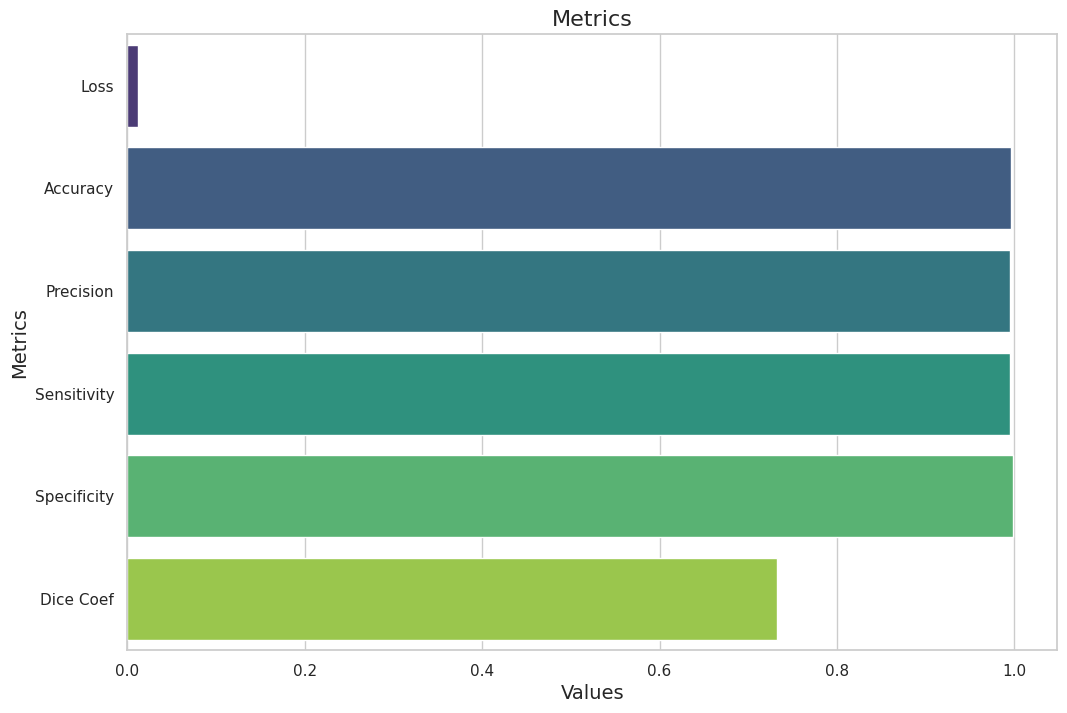

In [ ]:
#Plotting Evaluation metrics for U-Net

# Example log string
log_string = "32/32 [==============================] - 494s 15s/step - loss: 0.0119 - accuracy: 0.9958 - mean_io_u: 0.3756 - dice_coef: 0.7327 - precision: 0.9955 - sensitivity: 0.9946 - specificity: 0.9985 - dice_coef_necrotic: 0.7001 - dice_coef_edema: 0.8709 - dice_coef_enhancing: 0.8575 Test Loss : 0.011925283819437027 Test Accuracy : 0.9957624673843384"

# Define regular expressions for metric extraction
loss_pattern = re.compile(r'loss: ([0-9.]+)')
accuracy_pattern = re.compile(r'accuracy: ([0-9.]+)')
precision_pattern = re.compile(r'precision: ([0-9.]+)')
sensitivity_pattern = re.compile(r'sensitivity: ([0-9.]+)')
specificity_pattern = re.compile(r'specificity: ([0-9.]+)')
dice_coef_pattern = re.compile(r'dice_coef: ([0-9.]+)')

# Extract metrics using regular expressions
loss_match = loss_pattern.search(log_string)
accuracy_match = accuracy_pattern.search(log_string)
precision_match = precision_pattern.search(log_string)
sensitivity_match = sensitivity_pattern.search(log_string)
specificity_match = specificity_pattern.search(log_string)
dice_coef_match = dice_coef_pattern.search(log_string)

# Extract values from the matches
loss_value = float(loss_match.group(1)) if loss_match else None
accuracy_value = float(accuracy_match.group(1)) if accuracy_match else None
precision_value = float(precision_match.group(1)) if precision_match else None
sensitivity_value = float(sensitivity_match.group(1)) if sensitivity_match else None
specificity_value = float(specificity_match.group(1)) if specificity_match else None
dice_coef_value = float(dice_coef_match.group(1)) if dice_coef_match else None

# Stylish plot using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Plot the metrics
metrics_names = ['Loss', 'Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'Dice Coef']
metrics_values = [loss_value, accuracy_value, precision_value, sensitivity_value, specificity_value, dice_coef_value]

# Create a bar plot
sns.barplot(x=metrics_values, y=metrics_names, palette="viridis")

plt.title('Metrics', fontsize=16)
plt.xlabel('Values', fontsize=14)
plt.ylabel('Metrics', fontsize=14)
plt.show()

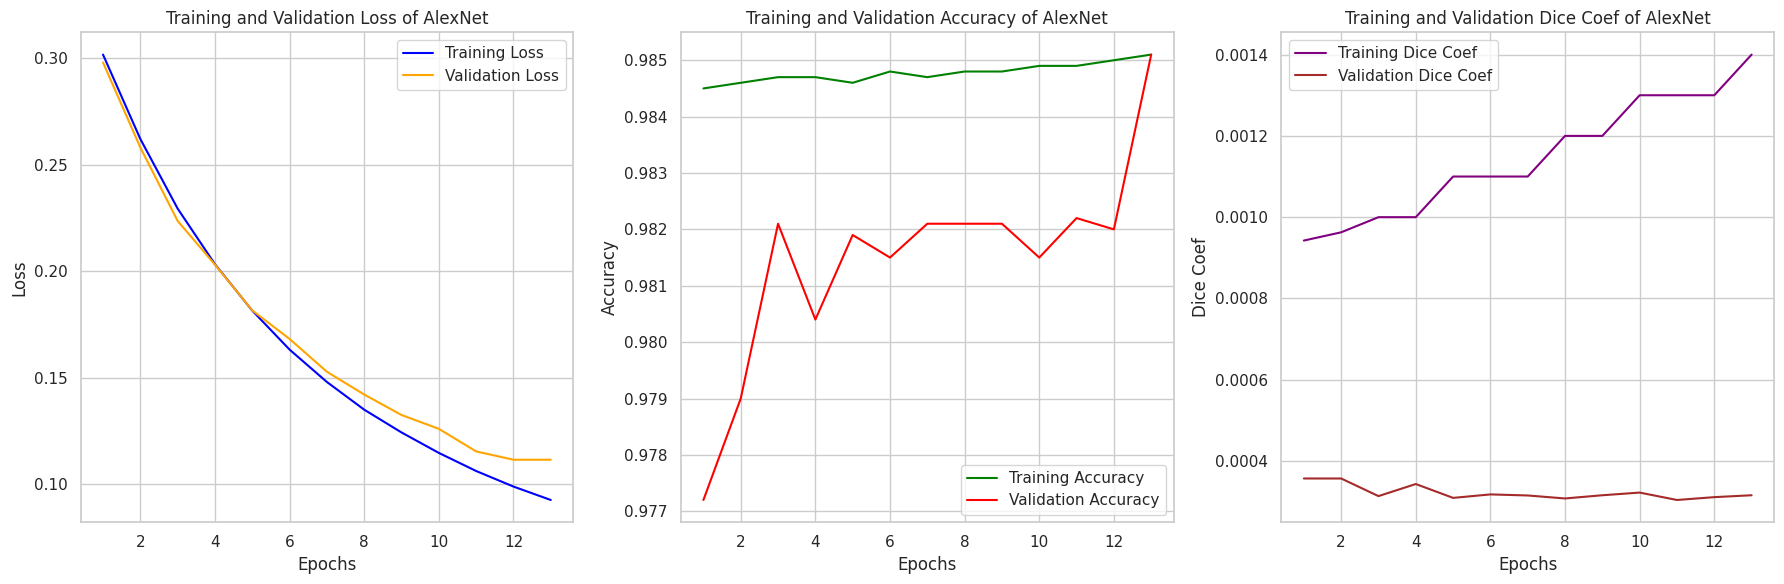

In [ ]:
# Plotting Evaluation metrics for AlexNet

# Replace the placeholder values with your actual metrics for each epoch
epochs = range(1, 14)  # Update the range based on the actual number of epochs

train_loss = [0.3018, 0.2622, 0.2295, 0.2034, 0.1816, 0.1633, 0.1481, 0.1351, 0.1244, 0.1148, 0.1063, 0.0990, 0.0927]  # Replace with your actual values
train_accuracy = [0.9845, 0.9846, 0.9847, 0.9847, 0.9846, 0.9848, 0.9847, 0.9848, 0.9848, 0.9849, 0.9849, 0.9850, 0.9851]  # Replace with your actual values
train_dice_coef = [9.4251e-04, 9.6276e-04, 0.0010, 0.0010, 0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013, 0.0014]  # Replace with your actual values

val_loss = [0.2981, 0.2582, 0.2237, 0.2032, 0.1817, 0.1683, 0.1529, 0.1422, 0.1326, 0.1261, 0.1155, 0.1116, 0.1116]  # Replace with your actual values
val_accuracy = [0.9772, 0.9790, 0.9821, 0.9804, 0.9819, 0.9815, 0.9821, 0.9821, 0.9821, 0.9815, 0.9822, 0.9820, 0.9851]  # Replace with your actual values
val_dice_coef = [3.5710e-04, 3.5707e-04, 3.1376e-04, 3.4349e-04, 3.0937e-04, 3.1793e-04, 3.1530e-04, 3.0797e-04, 3.1586e-04, 3.2242e-04, 3.0422e-04, 3.1120e-04, 3.1586e-04]  # Replace with your actual values

# Plotting training and validation metrics
plt.figure(figsize=(18, 6))

# Plot training loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss of AlexNet')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy', color='green')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy of AlexNet')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training dice_coef
plt.subplot(1, 3, 3)
plt.plot(epochs, train_dice_coef, label='Training Dice Coef', color='purple')
plt.plot(epochs, val_dice_coef, label='Validation Dice Coef', color='brown')
plt.title('Training and Validation Dice Coef of AlexNet')
plt.xlabel('Epochs')
plt.ylabel('Dice Coef')
plt.legend()

plt.tight_layout()
plt.show()

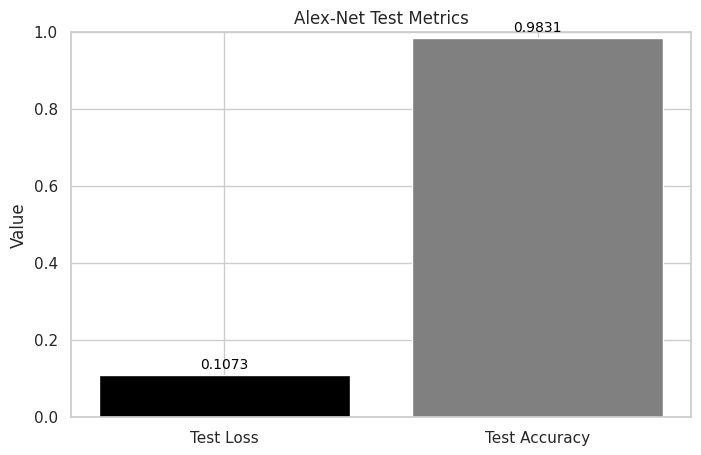

In [ ]:
# Plotting test loss and accuracy of AlexNet

# Test metrics
test_loss = 0.1073
test_accuracy = 0.9831

# Plotting
plt.figure(figsize=(8, 5))

# Bar chart for Test Loss and Test Accuracy
metrics = ['Test Loss', 'Test Accuracy']
values = [test_loss, test_accuracy]

plt.bar(metrics, values, color=['black', 'gray'])
plt.title('Alex-Net Test Metrics')
plt.ylabel('Value')
plt.ylim(0, 1)  # Adjust the y-axis limits based on your metric values

# Display the values on top of the bars
for i, value in enumerate(values):
    plt.text(i, value + 0.01, f'{value:.4f}', ha='center', va='bottom', fontsize=10, color='black')

plt.show()